# BERT (multi-output)

In [ ]:
!pip install -U "datasets==2.21.0" "aiohttp>=3.9.5" "evaluate" "transformers>=4.44"

In [13]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from evaluate import load
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"
#  You can install and import any other libraries if needed

In [2]:
# Some Chinese punctuations will be tokenized as [UNK], so we replace them with English ones
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [3]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

In [5]:
from datasets import load_dataset, DownloadConfig
from torch.utils.data import Dataset

dl_cfg = DownloadConfig(max_retries=5, resume_download=True)
SICK_LABEL2ID = {"NEUTRAL": 0, "ENTAILMENT": 1, "CONTRADICTION": 2}

class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]

        ds = None
        try:
            ds = load_dataset(
                "SemEvalWorkshop/sem_eval_2014_task_1",
                "sick", 
                split=split,
                trust_remote_code=True,
                cache_dir="./cache/",
                download_config=dl_cfg
            )
        except Exception:
            raw = load_dataset("sick", split=split, cache_dir="./cache/", download_config=dl_cfg)
            def _map_fields(d):
                premise = d.get("sentence_A") or d.get("sentence1") or d.get("premise")
                hypothesis = d.get("sentence_B") or d.get("sentence2") or d.get("hypothesis")
                rel = float(d["relatedness_score"])
                lbl = d.get("entailment_label") or d.get("label") or d.get("entailment_judgement")
                ent = SICK_LABEL2ID[lbl.upper()] if isinstance(lbl, str) else int(lbl)
                return {
                    "premise": premise,
                    "hypothesis": hypothesis,
                    "relatedness_score": rel,
                    "entailment_judgement": ent,
                }
            ds = raw.map(_map_fields, remove_columns=raw.column_names)

        self.data = ds.to_list()

    def __getitem__(self, index):
        d = self.data[index]
        prem, hypo = d["premise"], d["hypothesis"]
        for zh, en in token_replacement:
            prem = prem.replace(zh, en)
            hypo = hypo.replace(zh, en)

        ent = d.get("entailment_judgement", d.get("entailment_judgment"))
        return {
            "premise": prem,
            "hypothesis": hypo,
            "relatedness_score": float(d["relatedness_score"]),
            "entailment_judgement": int(ent),
        }

    def __len__(self):
        return len(self.data)


data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}


In [27]:
# Define the hyperparameters
# You can modify these values if needed
lr = 2e-5
epochs = 30
train_batch_size = 32
validation_batch_size = 32

In [28]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # 1) 取文本
    premises   = [b["premise"] for b in batch]
    hypotheses = [b["hypothesis"] for b in batch]

    # 2) 句對編碼（BERT：input_ids / token_type_ids / attention_mask）
    enc = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=256,          
        return_tensors="pt"
    )

    # 3) 兩個標籤
    # 回歸任務：relatedness_score 
    y_reg = torch.tensor(
        [float(b["relatedness_score"]) for b in batch],
        dtype=torch.float32
    ).unsqueeze(-1)

    # 分類任務：entailment_judgement
    y_cls = torch.tensor(
        [int(b["entailment_judgement"]) for b in batch],
        dtype=torch.long
    )

    return enc, y_reg, y_cls

# TODO1-2: Define your DataLoader
train_ds = SemevalDataset(split="train")
val_ds   = SemevalDataset(split="validation")
test_ds  = SemevalDataset(split="test")

pin = (device == "cuda")

dl_train = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=pin
)

dl_validation = DataLoader(
    val_ds,
    batch_size=validation_batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=pin
)

dl_test = DataLoader(
    test_ds,
    batch_size=validation_batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=pin
)

In [29]:
# TODO2: Construct your model
class MultiLabelModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        from transformers import BertModel
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

        hidden_size = self.bert.config.hidden_size  
        dropout_prob = 0.15

        self.dropout = torch.nn.Dropout(dropout_prob)
        self.reg_head = torch.nn.Linear(hidden_size, 1)
        self.cls_head = torch.nn.Linear(hidden_size, 3)

        torch.nn.init.xavier_uniform_(self.reg_head.weight)
        torch.nn.init.xavier_uniform_(self.cls_head.weight)

    def forward(self, **kwargs):
        out = self.bert(**kwargs, return_dict=True)

        cls_emb = out.last_hidden_state[:, 0, :] 
        cls_emb = self.dropout(cls_emb)

        # 兩個輸出：回歸 + 分類
        y_reg = self.reg_head(cls_emb)  
        y_cls = self.cls_head(cls_emb)  

        return y_reg, y_cls

In [30]:
# TODO3: Define your optimizer and loss function
model = MultiLabelModel().to(device)

# TODO3-1: Define your Optimizer
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

# TODO3-2: Define your loss functions (you should have two)
# 回歸任務：relatedness_score → 使用 MSELoss
# 分類任務：entailment_judgement → 使用 CrossEntropyLoss

loss_reg = nn.MSELoss()
loss_cls = nn.CrossEntropyLoss()

# scoring functions
psr = load("pearsonr")   # for regression evaluation
acc = load("accuracy")   # for classification evaluation

Validation epoch [1/30]: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


[Valid] Epoch 1: Pearson=0.8615, Acc=0.8160
  ↳ Save best checkpoint.


Validation epoch [2/30]: 100%|██████████| 16/16 [00:00<00:00, 36.12it/s]


[Valid] Epoch 2: Pearson=0.8772, Acc=0.8500
  ↳ Save best checkpoint.


Validation epoch [3/30]: 100%|██████████| 16/16 [00:00<00:00, 38.24it/s]


[Valid] Epoch 3: Pearson=0.8813, Acc=0.8460
  ↳ Save best checkpoint.


Validation epoch [4/30]: 100%|██████████| 16/16 [00:00<00:00, 36.04it/s]


[Valid] Epoch 4: Pearson=0.8829, Acc=0.8600
  ↳ Save best checkpoint.


Validation epoch [5/30]: 100%|██████████| 16/16 [00:00<00:00, 40.28it/s]


[Valid] Epoch 5: Pearson=0.8729, Acc=0.8320


Validation epoch [6/30]: 100%|██████████| 16/16 [00:00<00:00, 40.96it/s]


[Valid] Epoch 6: Pearson=0.8735, Acc=0.8360


Validation epoch [7/30]: 100%|██████████| 16/16 [00:00<00:00, 38.76it/s]


[Valid] Epoch 7: Pearson=0.8877, Acc=0.8640
  ↳ Save best checkpoint.


Validation epoch [8/30]: 100%|██████████| 16/16 [00:00<00:00, 39.15it/s]


[Valid] Epoch 8: Pearson=0.8888, Acc=0.8600


Validation epoch [9/30]: 100%|██████████| 16/16 [00:00<00:00, 36.75it/s]


[Valid] Epoch 9: Pearson=0.8892, Acc=0.8700
  ↳ Save best checkpoint.


Validation epoch [10/30]: 100%|██████████| 16/16 [00:00<00:00, 35.79it/s]


[Valid] Epoch 10: Pearson=0.8798, Acc=0.8600


Validation epoch [11/30]: 100%|██████████| 16/16 [00:00<00:00, 34.78it/s]


[Valid] Epoch 11: Pearson=0.8655, Acc=0.8540


Validation epoch [12/30]: 100%|██████████| 16/16 [00:00<00:00, 37.97it/s]


[Valid] Epoch 12: Pearson=0.8780, Acc=0.8520


Validation epoch [13/30]: 100%|██████████| 16/16 [00:00<00:00, 38.37it/s]


[Valid] Epoch 13: Pearson=0.8652, Acc=0.8620


Validation epoch [14/30]: 100%|██████████| 16/16 [00:00<00:00, 38.48it/s]


[Valid] Epoch 14: Pearson=0.8783, Acc=0.8660


Validation epoch [15/30]: 100%|██████████| 16/16 [00:00<00:00, 36.39it/s]


[Valid] Epoch 15: Pearson=0.8756, Acc=0.8640


Validation epoch [16/30]: 100%|██████████| 16/16 [00:00<00:00, 40.87it/s]


[Valid] Epoch 16: Pearson=0.8784, Acc=0.8540


Validation epoch [17/30]: 100%|██████████| 16/16 [00:00<00:00, 37.21it/s]


[Valid] Epoch 17: Pearson=0.8806, Acc=0.8540


Validation epoch [18/30]: 100%|██████████| 16/16 [00:00<00:00, 36.65it/s]


[Valid] Epoch 18: Pearson=0.8811, Acc=0.8600


Validation epoch [19/30]: 100%|██████████| 16/16 [00:00<00:00, 36.26it/s]


[Valid] Epoch 19: Pearson=0.8784, Acc=0.8620


Validation epoch [20/30]: 100%|██████████| 16/16 [00:00<00:00, 38.39it/s]


[Valid] Epoch 20: Pearson=0.8819, Acc=0.8620


Validation epoch [21/30]: 100%|██████████| 16/16 [00:00<00:00, 35.49it/s]


[Valid] Epoch 21: Pearson=0.8743, Acc=0.8580


Validation epoch [22/30]: 100%|██████████| 16/16 [00:00<00:00, 40.32it/s]


[Valid] Epoch 22: Pearson=0.8733, Acc=0.8540


Validation epoch [23/30]: 100%|██████████| 16/16 [00:00<00:00, 40.53it/s]


[Valid] Epoch 23: Pearson=0.8847, Acc=0.8680


Validation epoch [24/30]: 100%|██████████| 16/16 [00:00<00:00, 34.66it/s]


[Valid] Epoch 24: Pearson=0.8784, Acc=0.8600


Validation epoch [25/30]: 100%|██████████| 16/16 [00:00<00:00, 37.87it/s]


[Valid] Epoch 25: Pearson=0.8827, Acc=0.8640


Validation epoch [26/30]: 100%|██████████| 16/16 [00:00<00:00, 37.34it/s]


[Valid] Epoch 26: Pearson=0.8817, Acc=0.8620


Validation epoch [27/30]: 100%|██████████| 16/16 [00:00<00:00, 37.30it/s]


[Valid] Epoch 27: Pearson=0.8761, Acc=0.8660


Validation epoch [28/30]: 100%|██████████| 16/16 [00:00<00:00, 36.29it/s]


[Valid] Epoch 28: Pearson=0.8853, Acc=0.8740
  ↳ Save best checkpoint.


Validation epoch [29/30]: 100%|██████████| 16/16 [00:00<00:00, 34.20it/s]


[Valid] Epoch 29: Pearson=0.8827, Acc=0.8580


Validation epoch [30/30]: 100%|██████████| 16/16 [00:00<00:00, 37.21it/s]


[Valid] Epoch 30: Pearson=0.8846, Acc=0.8600
Saved: ./saved_models/training_losses.png
Saved: ./saved_models/validation_metrics.png


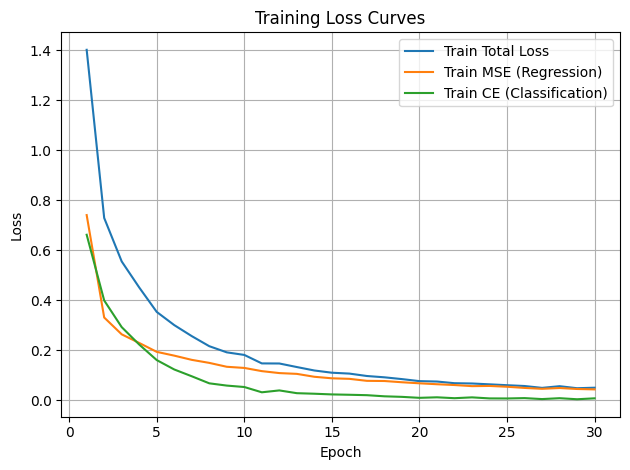

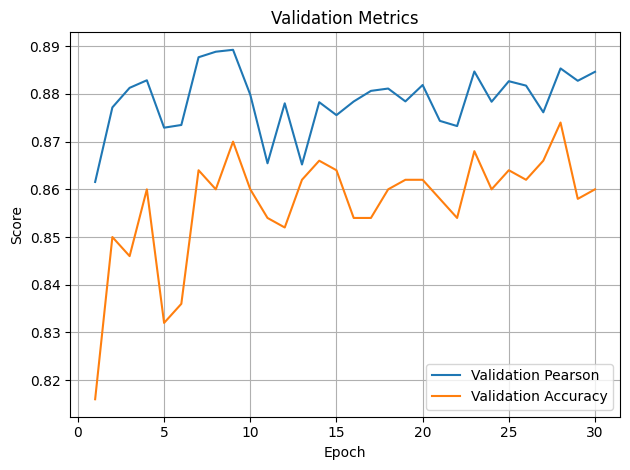

In [ ]:
os.makedirs("./saved_models", exist_ok=True)

best_score = 0.0
train_loss_hist, train_mse_hist, train_ce_hist = [], [], []
val_pearson_hist, val_acc_hist = [], []

for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    
    epoch_loss_sum = 0.0
    epoch_reg_sum  = 0.0
    epoch_cls_sum  = 0.0
    step_count     = 0

    for enc, y_reg, y_cls in pbar:
        optimizer.zero_grad(set_to_none=True)

        enc = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)        
        y_cls = y_cls.to(device)          

        pred_reg, logits_cls = model(**enc)

        l_reg = loss_reg(pred_reg, y_reg)
        l_cls = loss_cls(logits_cls, y_cls)
        loss  = l_reg + l_cls

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss_sum += loss.item()
        epoch_reg_sum  += l_reg.item()
        epoch_cls_sum  += l_cls.item()
        step_count     += 1

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "mse":  f"{l_reg.item():.4f}",
            "ce":   f"{l_cls.item():.4f}",
        })

    train_loss_hist.append(epoch_loss_sum / step_count)
    train_mse_hist.append(epoch_reg_sum / step_count)
    train_ce_hist.append(epoch_cls_sum / step_count)

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()

    reg_preds, reg_refs = [], []
    cls_preds, cls_refs = [], []
    with torch.no_grad():
        for enc, y_reg, y_cls in pbar:
            enc = {k: v.to(device) for k, v in enc.items()}
            y_reg = y_reg.to(device)
            y_cls = y_cls.to(device)

            pred_reg, logits_cls = model(**enc)

            # 收集 regression 預測與真值
            reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
            reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

            # 收集 classification 預測與真值
            cls_pred = logits_cls.argmax(dim=-1)
            cls_preds.extend(cls_pred.detach().cpu().tolist())
            cls_refs.extend(y_cls.detach().cpu().tolist())

    pearson_corr = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
    accuracy     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]
    print(f"[Valid] Epoch {ep+1}: Pearson={pearson_corr:.4f}, Acc={accuracy:.4f}")

    val_pearson_hist.append(float(pearson_corr))
    val_acc_hist.append(float(accuracy))
    
    cur_score = pearson_corr + accuracy
    if cur_score > best_score:
        best_score = cur_score
        torch.save(model.state_dict(), "./saved_models/best_model.ckpt")
        print("  ↳ Save best checkpoint.")
        
# 將輸出繪製出來
epochs_axis = list(range(1, epochs + 1))

plt.figure()
plt.plot(epochs_axis, train_loss_hist, label="Train Total Loss")
plt.plot(epochs_axis, train_mse_hist,  label="Train MSE (Regression)")
plt.plot(epochs_axis, train_ce_hist,   label="Train CE (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/BERT_training_losses.png", dpi=200)

plt.figure()
plt.plot(epochs_axis, val_pearson_hist, label="Validation Pearson")
plt.plot(epochs_axis, val_acc_hist,     label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/BERT_validation_metrics.png", dpi=200)

print("Saved: ./saved_models/BERT_training_losses.png")
print("Saved: ./saved_models/BERT_validation_metrics.png")

In [32]:
# Load the model
model = MultiLabelModel().to(device)
model.load_state_dict(torch.load(f"./saved_models/best_model.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model.eval()

# TODO6: Write the test loop
reg_preds, reg_refs = [], []
cls_preds, cls_refs = [], []

with torch.no_grad():
    for enc, y_reg, y_cls in pbar:
        enc   = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)
        y_cls = y_cls.to(device)

        pred_reg, logits_cls = model(**enc)

        # 收集回歸預測/真值
        reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
        reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

        # 收集分類預測/真值
        cls_pred = logits_cls.argmax(dim=-1)
        cls_preds.extend(cls_pred.detach().cpu().tolist())
        cls_refs.extend(y_cls.detach().cpu().tolist())

test_pearson = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
test_acc     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]

print(f"[Test] Pearson={test_pearson:.4f} | Accuracy={test_acc:.4f}")

Test: 100%|██████████| 154/154 [00:02<00:00, 64.75it/s]


[Test] Pearson=0.8903 | Accuracy=0.8750


# RoBERTa (multi-output)

In [33]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base", cache_dir="./cache/")

In [35]:
from transformers import RobertaModel

class MultiLabelModel_RoBERTa(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.roberta = RobertaModel.from_pretrained("FacebookAI/roberta-base", cache_dir="./cache/")
        hidden = self.roberta.config.hidden_size  
        self.dropout = torch.nn.Dropout(0.2)     
        self.reg_head = torch.nn.Linear(hidden, 1)
        self.cls_head = torch.nn.Linear(hidden, 3)
        torch.nn.init.xavier_uniform_(self.reg_head.weight)
        torch.nn.init.xavier_uniform_(self.cls_head.weight)

    def forward(self, **kwargs):
        kwargs.pop("token_type_ids", None)
        out = self.roberta(**kwargs, return_dict=True)
        cls = self.dropout(out.last_hidden_state[:, 0, :])  
        y_reg = self.reg_head(cls)
        y_cls = self.cls_head(cls)
        return y_reg, y_cls
    
model = MultiLabelModel_RoBERTa().to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

loss_reg = nn.MSELoss()
loss_cls = nn.CrossEntropyLoss()

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation epoch [1/30]: 100%|██████████| 16/16 [00:00<00:00, 39.91it/s]


[Valid] Epoch 1: Pearson=0.8454, Acc=0.8280
  ↳ Save best checkpoint.


Validation epoch [2/30]: 100%|██████████| 16/16 [00:00<00:00, 41.11it/s]


[Valid] Epoch 2: Pearson=0.8803, Acc=0.8660
  ↳ Save best checkpoint.


Validation epoch [3/30]: 100%|██████████| 16/16 [00:00<00:00, 41.99it/s]


[Valid] Epoch 3: Pearson=0.8827, Acc=0.8960
  ↳ Save best checkpoint.


Validation epoch [4/30]: 100%|██████████| 16/16 [00:00<00:00, 37.07it/s]


[Valid] Epoch 4: Pearson=0.9017, Acc=0.9000
  ↳ Save best checkpoint.


Validation epoch [5/30]: 100%|██████████| 16/16 [00:00<00:00, 40.06it/s]


[Valid] Epoch 5: Pearson=0.8957, Acc=0.8960


Validation epoch [6/30]: 100%|██████████| 16/16 [00:00<00:00, 41.69it/s]


[Valid] Epoch 6: Pearson=0.9066, Acc=0.8980
  ↳ Save best checkpoint.


Validation epoch [7/30]: 100%|██████████| 16/16 [00:00<00:00, 40.00it/s]


[Valid] Epoch 7: Pearson=0.9021, Acc=0.9020


Validation epoch [8/30]: 100%|██████████| 16/16 [00:00<00:00, 40.48it/s]


[Valid] Epoch 8: Pearson=0.9029, Acc=0.8800


Validation epoch [9/30]: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


[Valid] Epoch 9: Pearson=0.9049, Acc=0.8960


Validation epoch [10/30]: 100%|██████████| 16/16 [00:00<00:00, 39.86it/s]


[Valid] Epoch 10: Pearson=0.8988, Acc=0.8880


Validation epoch [11/30]: 100%|██████████| 16/16 [00:00<00:00, 38.09it/s]


[Valid] Epoch 11: Pearson=0.9035, Acc=0.8900


Validation epoch [12/30]: 100%|██████████| 16/16 [00:00<00:00, 40.56it/s]


[Valid] Epoch 12: Pearson=0.9035, Acc=0.8860


Validation epoch [13/30]: 100%|██████████| 16/16 [00:00<00:00, 41.62it/s]


[Valid] Epoch 13: Pearson=0.9022, Acc=0.8960


Validation epoch [14/30]: 100%|██████████| 16/16 [00:00<00:00, 41.16it/s]


[Valid] Epoch 14: Pearson=0.9033, Acc=0.8860


Validation epoch [15/30]: 100%|██████████| 16/16 [00:00<00:00, 41.19it/s]


[Valid] Epoch 15: Pearson=0.9012, Acc=0.8880


Validation epoch [16/30]: 100%|██████████| 16/16 [00:00<00:00, 41.18it/s]


[Valid] Epoch 16: Pearson=0.9016, Acc=0.8840


Validation epoch [17/30]: 100%|██████████| 16/16 [00:00<00:00, 39.03it/s]


[Valid] Epoch 17: Pearson=0.9042, Acc=0.8880


Validation epoch [18/30]: 100%|██████████| 16/16 [00:00<00:00, 41.35it/s]


[Valid] Epoch 18: Pearson=0.8987, Acc=0.8860


Validation epoch [19/30]: 100%|██████████| 16/16 [00:00<00:00, 41.92it/s]


[Valid] Epoch 19: Pearson=0.9028, Acc=0.8840


Validation epoch [20/30]: 100%|██████████| 16/16 [00:00<00:00, 40.13it/s]


[Valid] Epoch 20: Pearson=0.9002, Acc=0.8760


Validation epoch [21/30]: 100%|██████████| 16/16 [00:00<00:00, 40.19it/s]


[Valid] Epoch 21: Pearson=0.8845, Acc=0.8720


Validation epoch [22/30]: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


[Valid] Epoch 22: Pearson=0.8983, Acc=0.8860


Validation epoch [23/30]: 100%|██████████| 16/16 [00:00<00:00, 39.87it/s]


[Valid] Epoch 23: Pearson=0.9011, Acc=0.8940


Validation epoch [24/30]: 100%|██████████| 16/16 [00:00<00:00, 40.24it/s]


[Valid] Epoch 24: Pearson=0.8967, Acc=0.8860


Validation epoch [25/30]: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


[Valid] Epoch 25: Pearson=0.8981, Acc=0.8960


Validation epoch [26/30]: 100%|██████████| 16/16 [00:00<00:00, 38.24it/s]


[Valid] Epoch 26: Pearson=0.8947, Acc=0.8960


Validation epoch [27/30]: 100%|██████████| 16/16 [00:00<00:00, 41.41it/s]


[Valid] Epoch 27: Pearson=0.9007, Acc=0.8980


Validation epoch [28/30]: 100%|██████████| 16/16 [00:00<00:00, 41.27it/s]


[Valid] Epoch 28: Pearson=0.8985, Acc=0.8920


Validation epoch [29/30]: 100%|██████████| 16/16 [00:00<00:00, 40.12it/s]


[Valid] Epoch 29: Pearson=0.9008, Acc=0.8900


Validation epoch [30/30]: 100%|██████████| 16/16 [00:00<00:00, 41.77it/s]


[Valid] Epoch 30: Pearson=0.8971, Acc=0.8960
Saved: ./saved_models/RoBERT_training_losses.png
Saved: ./saved_models/RoBERT_validation_metrics.png


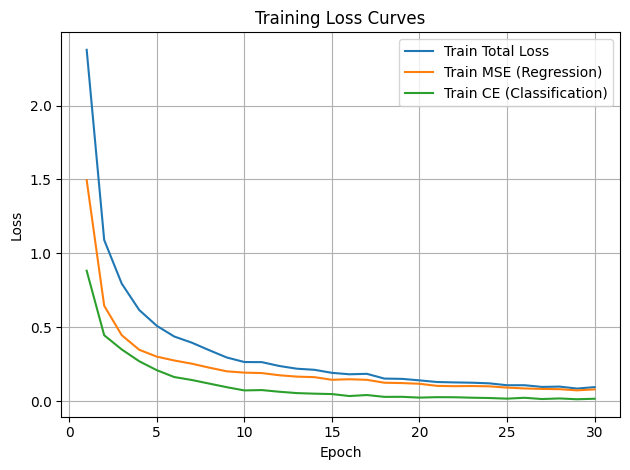

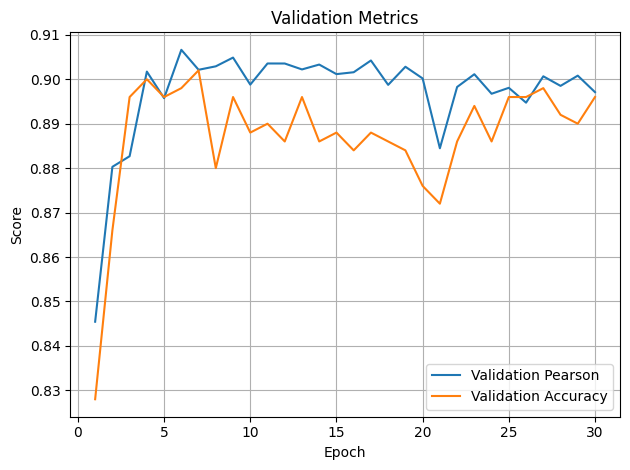

In [36]:
os.makedirs("./saved_models", exist_ok=True)

best_score = 0.0
train_loss_hist, train_mse_hist, train_ce_hist = [], [], []
val_pearson_hist, val_acc_hist = [], []

for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    
    epoch_loss_sum = 0.0
    epoch_reg_sum  = 0.0
    epoch_cls_sum  = 0.0
    step_count     = 0

    for enc, y_reg, y_cls in pbar:
        optimizer.zero_grad(set_to_none=True)

        enc = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)        
        y_cls = y_cls.to(device)          

        pred_reg, logits_cls = model(**enc)

        l_reg = loss_reg(pred_reg, y_reg)
        l_cls = loss_cls(logits_cls, y_cls)
        loss  = l_reg + l_cls

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss_sum += loss.item()
        epoch_reg_sum  += l_reg.item()
        epoch_cls_sum  += l_cls.item()
        step_count     += 1

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "mse":  f"{l_reg.item():.4f}",
            "ce":   f"{l_cls.item():.4f}",
        })

    train_loss_hist.append(epoch_loss_sum / step_count)
    train_mse_hist.append(epoch_reg_sum / step_count)
    train_ce_hist.append(epoch_cls_sum / step_count)

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()

    reg_preds, reg_refs = [], []
    cls_preds, cls_refs = [], []
    with torch.no_grad():
        for enc, y_reg, y_cls in pbar:
            enc = {k: v.to(device) for k, v in enc.items()}
            y_reg = y_reg.to(device)
            y_cls = y_cls.to(device)

            pred_reg, logits_cls = model(**enc)

            # 收集 regression 預測與真值
            reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
            reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

            # 收集 classification 預測與真值
            cls_pred = logits_cls.argmax(dim=-1)
            cls_preds.extend(cls_pred.detach().cpu().tolist())
            cls_refs.extend(y_cls.detach().cpu().tolist())

    pearson_corr = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
    accuracy     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]
    print(f"[Valid] Epoch {ep+1}: Pearson={pearson_corr:.4f}, Acc={accuracy:.4f}")

    val_pearson_hist.append(float(pearson_corr))
    val_acc_hist.append(float(accuracy))
    
    cur_score = pearson_corr + accuracy
    if cur_score > best_score:
        best_score = cur_score
        torch.save(model.state_dict(), "./saved_models/best_RoBERT_model.ckpt")
        print("  ↳ Save best checkpoint.")
        
# 將輸出繪製出來
epochs_axis = list(range(1, epochs + 1))

plt.figure()
plt.plot(epochs_axis, train_loss_hist, label="Train Total Loss")
plt.plot(epochs_axis, train_mse_hist,  label="Train MSE (Regression)")
plt.plot(epochs_axis, train_ce_hist,   label="Train CE (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/RoBERT_training_losses.png", dpi=200)

plt.figure()
plt.plot(epochs_axis, val_pearson_hist, label="Validation Pearson")
plt.plot(epochs_axis, val_acc_hist,     label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/RoBERT_validation_metrics.png", dpi=200)

print("Saved: ./saved_models/RoBERT_training_losses.png")
print("Saved: ./saved_models/RoBERT_validation_metrics.png")

In [38]:
# Load the model
model = MultiLabelModel_RoBERTa().to(device)
model.load_state_dict(torch.load(f"./saved_models/best_RoBERT_model.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model.eval()

# TODO6: Write the test loop
reg_preds, reg_refs = [], []
cls_preds, cls_refs = [], []

with torch.no_grad():
    for enc, y_reg, y_cls in pbar:
        enc   = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)
        y_cls = y_cls.to(device)

        pred_reg, logits_cls = model(**enc)

        # 收集回歸預測/真值
        reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
        reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

        # 收集分類預測/真值
        cls_pred = logits_cls.argmax(dim=-1)
        cls_preds.extend(cls_pred.detach().cpu().tolist())
        cls_refs.extend(y_cls.detach().cpu().tolist())

test_pearson = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
test_acc     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]

print(f"[Test] Pearson={test_pearson:.4f} | Accuracy={test_acc:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Test: 100%|██████████| 154/154 [00:02<00:00, 64.30it/s]

[Test] Pearson=0.9033 | Accuracy=0.8924


# GPT-2 (multi-output)

In [39]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", cache_dir="./cache/")

tokenizer.pad_token = tokenizer.eos_token

In [40]:
from transformers import GPT2Model

class MultiLabelModel_GPT2(nn.Module):
    def __init__(self):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2", cache_dir="./cache/")
        hidden = self.gpt2.config.hidden_size  
        self.dropout = nn.Dropout(0.2)
        self.reg_head = nn.Linear(hidden, 1)
        self.cls_head = nn.Linear(hidden, 3)

        self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id

    def forward(self, **kwargs):
        kwargs.pop("token_type_ids", None)
        out = self.gpt2(**kwargs, return_dict=True)
        last_hidden = out.last_hidden_state
        last_token = (kwargs["attention_mask"].sum(dim=1) - 1).long()
        sent_emb = last_hidden[torch.arange(last_hidden.size(0)), last_token]
        sent_emb = self.dropout(sent_emb)

        y_reg = self.reg_head(sent_emb)
        y_cls = self.cls_head(sent_emb)
        return y_reg, y_cls

In [ ]:
def collate_fn(batch):
    texts = [f"Premise: {b['premise']} Hypothesis: {b['hypothesis']}" for b in batch]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    y_reg = torch.tensor([float(b["relatedness_score"]) for b in batch], dtype=torch.float32).unsqueeze(-1)
    y_cls = torch.tensor([int(b["entailment_judgement"]) for b in batch], dtype=torch.long)
    return enc, y_reg, y_cls

In [42]:
model = MultiLabelModel_GPT2().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_reg = nn.MSELoss()
loss_cls = nn.CrossEntropyLoss()

Validation epoch [1/30]: 100%|██████████| 16/16 [00:00<00:00, 33.19it/s]


[Valid] Epoch 1: Pearson=0.7387, Acc=0.7580
  ↳ Save best checkpoint.


Validation epoch [2/30]: 100%|██████████| 16/16 [00:00<00:00, 34.19it/s]


[Valid] Epoch 2: Pearson=0.8237, Acc=0.8340
  ↳ Save best checkpoint.


Validation epoch [3/30]: 100%|██████████| 16/16 [00:00<00:00, 35.56it/s]


[Valid] Epoch 3: Pearson=0.8359, Acc=0.8540
  ↳ Save best checkpoint.


Validation epoch [4/30]: 100%|██████████| 16/16 [00:00<00:00, 34.82it/s]


[Valid] Epoch 4: Pearson=0.8509, Acc=0.8580
  ↳ Save best checkpoint.


Validation epoch [5/30]: 100%|██████████| 16/16 [00:00<00:00, 35.12it/s]


[Valid] Epoch 5: Pearson=0.8552, Acc=0.8700
  ↳ Save best checkpoint.


Validation epoch [6/30]: 100%|██████████| 16/16 [00:00<00:00, 34.39it/s]


[Valid] Epoch 6: Pearson=0.8605, Acc=0.8520


Validation epoch [7/30]: 100%|██████████| 16/16 [00:00<00:00, 35.88it/s]


[Valid] Epoch 7: Pearson=0.8571, Acc=0.8640


Validation epoch [8/30]: 100%|██████████| 16/16 [00:00<00:00, 32.86it/s]


[Valid] Epoch 8: Pearson=0.8625, Acc=0.8680
  ↳ Save best checkpoint.


Validation epoch [9/30]: 100%|██████████| 16/16 [00:00<00:00, 33.24it/s]


[Valid] Epoch 9: Pearson=0.8690, Acc=0.8800
  ↳ Save best checkpoint.


Validation epoch [10/30]: 100%|██████████| 16/16 [00:00<00:00, 34.02it/s]


[Valid] Epoch 10: Pearson=0.8606, Acc=0.8800


Validation epoch [11/30]: 100%|██████████| 16/16 [00:00<00:00, 35.47it/s]


[Valid] Epoch 11: Pearson=0.8586, Acc=0.8720


Validation epoch [12/30]: 100%|██████████| 16/16 [00:00<00:00, 32.01it/s]


[Valid] Epoch 12: Pearson=0.8575, Acc=0.8600


Validation epoch [13/30]: 100%|██████████| 16/16 [00:00<00:00, 34.05it/s]


[Valid] Epoch 13: Pearson=0.8615, Acc=0.8760


Validation epoch [14/30]: 100%|██████████| 16/16 [00:00<00:00, 34.88it/s]


[Valid] Epoch 14: Pearson=0.8600, Acc=0.8620


Validation epoch [15/30]: 100%|██████████| 16/16 [00:00<00:00, 34.47it/s]


[Valid] Epoch 15: Pearson=0.8535, Acc=0.8700


Validation epoch [16/30]: 100%|██████████| 16/16 [00:00<00:00, 34.20it/s]


[Valid] Epoch 16: Pearson=0.8607, Acc=0.8760


Validation epoch [17/30]: 100%|██████████| 16/16 [00:00<00:00, 34.19it/s]


[Valid] Epoch 17: Pearson=0.8624, Acc=0.8800


Validation epoch [18/30]: 100%|██████████| 16/16 [00:00<00:00, 35.89it/s]


[Valid] Epoch 18: Pearson=0.8624, Acc=0.8720


Validation epoch [19/30]: 100%|██████████| 16/16 [00:00<00:00, 32.89it/s]


[Valid] Epoch 19: Pearson=0.8567, Acc=0.8700


Validation epoch [20/30]: 100%|██████████| 16/16 [00:00<00:00, 35.26it/s]


[Valid] Epoch 20: Pearson=0.8576, Acc=0.8700


Validation epoch [21/30]: 100%|██████████| 16/16 [00:00<00:00, 32.26it/s]


[Valid] Epoch 21: Pearson=0.8584, Acc=0.8700


Validation epoch [22/30]: 100%|██████████| 16/16 [00:00<00:00, 34.09it/s]


[Valid] Epoch 22: Pearson=0.8597, Acc=0.8680


Validation epoch [23/30]: 100%|██████████| 16/16 [00:00<00:00, 34.39it/s]


[Valid] Epoch 23: Pearson=0.8582, Acc=0.8680


Validation epoch [24/30]: 100%|██████████| 16/16 [00:00<00:00, 33.38it/s]


[Valid] Epoch 24: Pearson=0.8560, Acc=0.8640


Validation epoch [25/30]: 100%|██████████| 16/16 [00:00<00:00, 32.51it/s]


[Valid] Epoch 25: Pearson=0.8580, Acc=0.8740


Validation epoch [26/30]: 100%|██████████| 16/16 [00:00<00:00, 35.24it/s]


[Valid] Epoch 26: Pearson=0.8602, Acc=0.8720


Validation epoch [27/30]: 100%|██████████| 16/16 [00:00<00:00, 34.96it/s]


[Valid] Epoch 27: Pearson=0.8503, Acc=0.8580


Validation epoch [28/30]: 100%|██████████| 16/16 [00:00<00:00, 34.24it/s]


[Valid] Epoch 28: Pearson=0.8493, Acc=0.8740


Validation epoch [29/30]: 100%|██████████| 16/16 [00:00<00:00, 33.30it/s]


[Valid] Epoch 29: Pearson=0.8573, Acc=0.8740


Validation epoch [30/30]: 100%|██████████| 16/16 [00:00<00:00, 34.86it/s]


[Valid] Epoch 30: Pearson=0.8547, Acc=0.8720
Saved: ./saved_models/gpt2_training_losses.png
Saved: ./saved_models/gpt2_validation_metrics.png


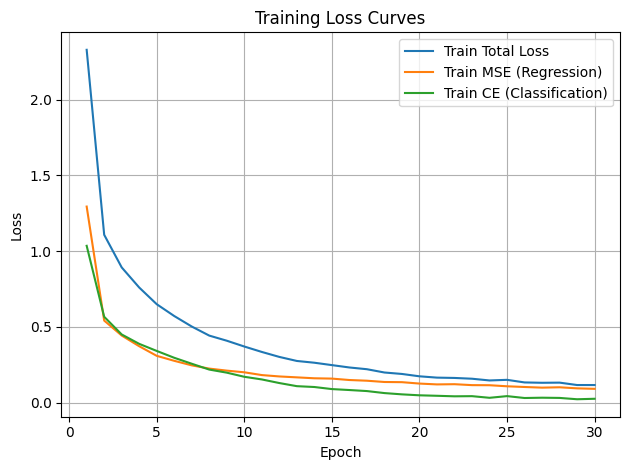

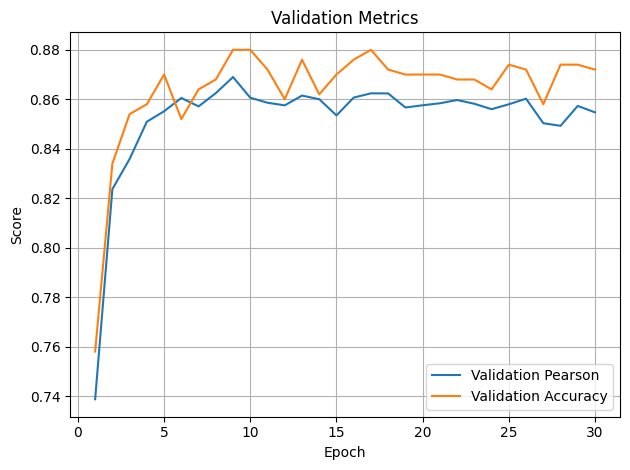

In [43]:
os.makedirs("./saved_models", exist_ok=True)

best_score = 0.0
train_loss_hist, train_mse_hist, train_ce_hist = [], [], []
val_pearson_hist, val_acc_hist = [], []

for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    
    epoch_loss_sum = 0.0
    epoch_reg_sum  = 0.0
    epoch_cls_sum  = 0.0
    step_count     = 0

    for enc, y_reg, y_cls in pbar:
        optimizer.zero_grad(set_to_none=True)

        enc = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)        
        y_cls = y_cls.to(device)          

        pred_reg, logits_cls = model(**enc)

        l_reg = loss_reg(pred_reg, y_reg)
        l_cls = loss_cls(logits_cls, y_cls)
        loss  = l_reg + l_cls

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss_sum += loss.item()
        epoch_reg_sum  += l_reg.item()
        epoch_cls_sum  += l_cls.item()
        step_count     += 1

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "mse":  f"{l_reg.item():.4f}",
            "ce":   f"{l_cls.item():.4f}",
        })

    train_loss_hist.append(epoch_loss_sum / step_count)
    train_mse_hist.append(epoch_reg_sum / step_count)
    train_ce_hist.append(epoch_cls_sum / step_count)

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()

    reg_preds, reg_refs = [], []
    cls_preds, cls_refs = [], []
    with torch.no_grad():
        for enc, y_reg, y_cls in pbar:
            enc = {k: v.to(device) for k, v in enc.items()}
            y_reg = y_reg.to(device)
            y_cls = y_cls.to(device)

            pred_reg, logits_cls = model(**enc)

            # 收集 regression 預測與真值
            reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
            reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

            # 收集 classification 預測與真值
            cls_pred = logits_cls.argmax(dim=-1)
            cls_preds.extend(cls_pred.detach().cpu().tolist())
            cls_refs.extend(y_cls.detach().cpu().tolist())

    pearson_corr = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
    accuracy     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]
    print(f"[Valid] Epoch {ep+1}: Pearson={pearson_corr:.4f}, Acc={accuracy:.4f}")

    val_pearson_hist.append(float(pearson_corr))
    val_acc_hist.append(float(accuracy))
    
    cur_score = pearson_corr + accuracy
    if cur_score > best_score:
        best_score = cur_score
        torch.save(model.state_dict(), "./saved_models/gpt2_best_model.ckpt")
        print("  ↳ Save best checkpoint.")
        
# 將輸出繪製出來
epochs_axis = list(range(1, epochs + 1))

plt.figure()
plt.plot(epochs_axis, train_loss_hist, label="Train Total Loss")
plt.plot(epochs_axis, train_mse_hist,  label="Train MSE (Regression)")
plt.plot(epochs_axis, train_ce_hist,   label="Train CE (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/gpt2_training_losses.png", dpi=200)

plt.figure()
plt.plot(epochs_axis, val_pearson_hist, label="Validation Pearson")
plt.plot(epochs_axis, val_acc_hist,     label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./saved_models/gpt2_validation_metrics.png", dpi=200)

print("Saved: ./saved_models/gpt2_training_losses.png")
print("Saved: ./saved_models/gpt2_validation_metrics.png")

In [44]:
# Load the model
model = MultiLabelModel_GPT2().to(device)
model.load_state_dict(torch.load(f"./saved_models/gpt2_best_model.ckpt", weights_only=True))

# Test Loop
pbar = tqdm(dl_test, desc="Test")
model.eval()

# TODO6: Write the test loop
reg_preds, reg_refs = [], []
cls_preds, cls_refs = [], []

with torch.no_grad():
    for enc, y_reg, y_cls in pbar:
        enc   = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)
        y_cls = y_cls.to(device)

        pred_reg, logits_cls = model(**enc)

        # 收集回歸預測/真值
        reg_preds.extend(pred_reg.squeeze(-1).detach().cpu().tolist())
        reg_refs.extend(y_reg.squeeze(-1).detach().cpu().tolist())

        # 收集分類預測/真值
        cls_pred = logits_cls.argmax(dim=-1)
        cls_preds.extend(cls_pred.detach().cpu().tolist())
        cls_refs.extend(y_cls.detach().cpu().tolist())

test_pearson = psr.compute(predictions=reg_preds, references=reg_refs)["pearsonr"]
test_acc     = acc.compute(predictions=cls_preds, references=cls_refs)["accuracy"]

print(f"[Test] Pearson={test_pearson:.4f} | Accuracy={test_acc:.4f}")

Test: 100%|██████████| 154/154 [00:02<00:00, 56.52it/s]

[Test] Pearson=0.8635 | Accuracy=0.8731


# RoBERTa (single-output) vs. multi-output

### Regression

In [47]:
from transformers import RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup


token_replacement = [["：", ":"], ["，", ","], ["“", "\""], ["”", "\""], ["？", "?"], ["……", "..."], ["！", "!"]]
dl_cfg = DownloadConfig(max_retries=5, resume_download=True)
SICK_LABEL2ID = {"NEUTRAL": 0, "ENTAILMENT": 1, "CONTRADICTION": 2}

class SemevalDataset(Dataset):
    def __init__(self, split="train"):
        assert split in ["train", "validation", "test"]
        try:
            ds = load_dataset("SemEvalWorkshop/sem_eval_2014_task_1", "sick",
                            split=split, trust_remote_code=True,
                            cache_dir="./cache/", download_config=dl_cfg)
        except Exception:
            raw = load_dataset("sick", split=split, cache_dir="./cache/", download_config=dl_cfg)
            def _map(d):
                prem = d.get("sentence_A") or d.get("sentence1") or d.get("premise")
                hypo = d.get("sentence_B") or d.get("sentence2") or d.get("hypothesis")
                rel  = float(d["relatedness_score"])
                lbl  = d.get("entailment_label") or d.get("label") or d.get("entailment_judgement")
                ent  = SICK_LABEL2ID[lbl.upper()] if isinstance(lbl, str) else int(lbl)
                return {"premise": prem, "hypothesis": hypo,
                        "relatedness_score": rel, "entailment_judgement": ent}
            ds = raw.map(_map, remove_columns=raw.column_names)
        self.data = ds.to_list()

    def __getitem__(self, i):
        d = self.data[i].copy()
        for k in ["premise", "hypothesis"]:
            for czh, cen in token_replacement:
                d[k] = d[k].replace(czh, cen)
        return d

    def __len__(self): return len(self.data)

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", cache_dir="./cache/")
tokenizer.pad_token = tokenizer.eos_token  
def collate_fn(batch):
    premises   = [b["premise"] for b in batch]
    hypotheses = [b["hypothesis"] for b in batch]
    enc = tokenizer(premises, hypotheses, padding=True, truncation=True,
                    max_length=256, return_tensors="pt", return_token_type_ids=False)
    y_reg = torch.tensor([float(b["relatedness_score"]) for b in batch], dtype=torch.float32).unsqueeze(-1)
    return enc, y_reg

dl_train = DataLoader(SemevalDataset("train"),      batch_size=16, shuffle=True,  collate_fn=collate_fn)
dl_valid = DataLoader(SemevalDataset("validation"), batch_size=16, shuffle=False, collate_fn=collate_fn)
dl_test  = DataLoader(SemevalDataset("test"),       batch_size=16, shuffle=False, collate_fn=collate_fn)

class SingleTaskRegression(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.backbone = RobertaModel.from_pretrained("roberta-base", cache_dir="./cache/", add_pooling_layer=False)
        h = self.backbone.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.reg_head = nn.Linear(h, 1)

    def forward(self, **enc):
        out = self.backbone(**enc, return_dict=True)
        last_hidden = out.last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).float()
        emb = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        emb = self.dropout(emb)
        y_reg = self.reg_head(emb)
        return y_reg

model = SingleTaskRegression().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_reg = nn.MSELoss()
num_steps = len(dl_train) * 10  
scheduler = get_linear_schedule_with_warmup(optimizer,
    num_warmup_steps=int(0.1 * num_steps), num_training_steps=num_steps)

psr = load("pearsonr")


epochs = 10
best = -1e9
os.makedirs("./saved_models", exist_ok=True)
for ep in range(epochs):
    model.train()
    pbar = tqdm(dl_train, desc=f"[Reg] Train {ep+1}/{epochs}")
    for enc, y_reg in pbar:
        enc = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)

        pred = model(**enc)
        loss = loss_reg(pred, y_reg)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); scheduler.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # validation
    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for enc, y_reg in tqdm(dl_valid, desc="[Reg] Valid"):
            enc = {k: v.to(device) for k, v in enc.items()}
            y_reg = y_reg.to(device)
            pred = model(**enc)
            preds.extend(pred.squeeze(-1).cpu().tolist())
            refs.extend(y_reg.squeeze(-1).cpu().tolist())
    pearson = psr.compute(predictions=preds, references=refs)["pearsonr"]
    print(f"[Reg] Epoch {ep+1}: Pearson={pearson:.4f}")

    if pearson > best:
        best = pearson
        torch.save(model.state_dict(), "./saved_models/best_roberta_reg.ckpt")
        print("  ↳ Save best_roberta_reg.ckpt")

# ---------- Test ----------
model.load_state_dict(torch.load("./saved_models/best_roberta_reg.ckpt", map_location="cpu"))
model.to(device); model.eval()
preds, refs = [], []
with torch.no_grad():
    for enc, y_reg in tqdm(dl_test, desc="[Reg] Test"):
        enc = {k: v.to(device) for k, v in enc.items()}
        y_reg = y_reg.to(device)
        pred = model(**enc)
        preds.extend(pred.squeeze(-1).cpu().tolist())
        refs.extend(y_reg.squeeze(-1).cpu().tolist())
test_pearson = psr.compute(predictions=preds, references=refs)["pearsonr"]
print(f"[Reg][Test] Pearson={test_pearson:.4f}")


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 96.83it/s] 


[Reg] Epoch 1: Pearson=0.8634
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 105.31it/s]


[Reg] Epoch 2: Pearson=0.9013
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 94.85it/s]


[Reg] Epoch 3: Pearson=0.9007


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.33it/s]


[Reg] Epoch 4: Pearson=0.9067
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 98.87it/s] 


[Reg] Epoch 5: Pearson=0.8999


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 106.84it/s]


[Reg] Epoch 6: Pearson=0.9082
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.76it/s]


[Reg] Epoch 7: Pearson=0.9125
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 98.98it/s] 


[Reg] Epoch 8: Pearson=0.9162
  ↳ Save best_roberta_reg.ckpt


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 98.97it/s] 


[Reg] Epoch 9: Pearson=0.9126


[Reg] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


[Reg] Epoch 10: Pearson=0.9123


[Reg] Test: 100%|██████████| 308/308 [00:02<00:00, 115.29it/s]

[Reg][Test] Pearson=0.9126


### Classification

In [50]:
token_replacement = [["：", ":"], ["，", ","], ["“", "\""], ["”", "\""], ["？", "?"], ["……", "..."], ["！", "!"]]
dl_cfg = DownloadConfig(max_retries=5, resume_download=True)
SICK_LABEL2ID = {"NEUTRAL": 0, "ENTAILMENT": 1, "CONTRADICTION": 2}

class SemevalDataset(Dataset):
    def __init__(self, split="train"):
        assert split in ["train", "validation", "test"]
        try:
            ds = load_dataset("SemEvalWorkshop/sem_eval_2014_task_1", "sick",
                            split=split, trust_remote_code=True,
                            cache_dir="./cache/", download_config=dl_cfg)
        except Exception:
            raw = load_dataset("sick", split=split, cache_dir="./cache/", download_config=dl_cfg)
            def _map(d):
                prem = d.get("sentence_A") or d.get("sentence1") or d.get("premise")
                hypo = d.get("sentence_B") or d.get("sentence2") or d.get("hypothesis")
                rel  = float(d["relatedness_score"])
                lbl  = d.get("entailment_label") or d.get("label") or d.get("entailment_judgement")
                ent  = SICK_LABEL2ID[lbl.upper()] if isinstance(lbl, str) else int(lbl)
                return {"premise": prem, "hypothesis": hypo,
                        "relatedness_score": rel, "entailment_judgement": ent}
            ds = raw.map(_map, remove_columns=raw.column_names)
        self.data = ds.to_list()

    def __getitem__(self, i):
        d = self.data[i].copy()
        for k in ["premise", "hypothesis"]:
            for czh, cen in token_replacement:
                d[k] = d[k].replace(czh, cen)
        return d

    def __len__(self): return len(self.data)

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", cache_dir="./cache/")
tokenizer.pad_token = tokenizer.eos_token

SICK_LABEL2ID = {"NEUTRAL": 0, "ENTAILMENT": 1, "CONTRADICTION": 2}

def _extract_label_safe(d):
    for key in ("label_id", "entailment_judgement", "entailment_judgment",
                "entailment_label", "label"):
        if key in d and d[key] is not None:
            v = d[key]
            return SICK_LABEL2ID[v.upper()] if isinstance(v, str) else int(v)
    raise KeyError(f"No label field found. keys={list(d.keys())} sample={ {k:d[k] for k in list(d)[:5]} }")

def collate_fn(batch):
    prem = [b["premise"] for b in batch]
    hypo = [b["hypothesis"] for b in batch]
    enc = tokenizer(prem, hypo, padding=True, truncation=True, max_length=256,
                    return_tensors="pt", return_token_type_ids=False)
    y_cls = torch.tensor([_extract_label_safe(b) for b in batch], dtype=torch.long)
    return enc, y_cls


dl_train = DataLoader(SemevalDataset("train"),      batch_size=16, shuffle=True,  collate_fn=collate_fn)
dl_valid = DataLoader(SemevalDataset("validation"), batch_size=16, shuffle=False, collate_fn=collate_fn)
dl_test  = DataLoader(SemevalDataset("test"),       batch_size=16, shuffle=False, collate_fn=collate_fn)

class SingleTaskClassification(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.backbone = RobertaModel.from_pretrained("roberta-base", cache_dir="./cache/", add_pooling_layer=False)
        h = self.backbone.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.cls_head = nn.Linear(h, 3)

    def forward(self, **enc):
        out = self.backbone(**enc, return_dict=True)
        last_hidden = out.last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).float()
        emb = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)  # mean pooling
        emb = self.dropout(emb)
        logits = self.cls_head(emb)
        return logits

model = SingleTaskClassification().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_cls = nn.CrossEntropyLoss(label_smoothing=0.05)  
num_steps = len(dl_train) * 10  
scheduler = get_linear_schedule_with_warmup(optimizer,
    num_warmup_steps=int(0.1 * num_steps), num_training_steps=num_steps)

acc = load("accuracy")

epochs = 10
best = -1e9
os.makedirs("./saved_models", exist_ok=True)
for ep in range(epochs):
    model.train()
    pbar = tqdm(dl_train, desc=f"[Cls] Train {ep+1}/{epochs}")
    for enc, y_cls in pbar:
        enc = {k: v.to(device) for k, v in enc.items()}
        y_cls = y_cls.to(device)

        logits = model(**enc)
        loss = loss_cls(logits, y_cls)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); scheduler.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    preds, refs = [], []
    with torch.no_grad():
        for enc, y_cls in tqdm(dl_valid, desc="[Cls] Valid"):
            enc = {k: v.to(device) for k, v in enc.items()}
            y_cls = y_cls.to(device)
            logits = model(**enc)
            pred = logits.argmax(dim=-1)
            preds.extend(pred.cpu().tolist())
            refs.extend(y_cls.cpu().tolist())
    val_acc = acc.compute(predictions=preds, references=refs)["accuracy"]
    print(f"[Cls] Epoch {ep+1}: Acc={val_acc:.4f}")

    if val_acc > best:
        best = val_acc
        torch.save(model.state_dict(), "./saved_models/best_roberta_cls.ckpt")
        print("  ↳ Save best_roberta_cls.ckpt")

model.load_state_dict(torch.load("./saved_models/best_roberta_cls.ckpt", map_location="cpu"))
model.to(device); model.eval()
preds, refs = [], []
with torch.no_grad():
    for enc, y_cls in tqdm(dl_test, desc="[Cls] Test"):
        enc = {k: v.to(device) for k, v in enc.items()}
        y_cls = y_cls.to(device)
        logits = model(**enc)
        preds.extend(logits.argmax(dim=-1).cpu().tolist())
        refs.extend(y_cls.cpu().tolist())
test_acc = acc.compute(predictions=preds, references=refs)["accuracy"]
print(f"[Cls][Test] Acc={test_acc:.4f}")

[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 108.44it/s]


[Cls] Epoch 1: Acc=0.8700
  ↳ Save best_roberta_cls.ckpt


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.94it/s]


[Cls] Epoch 2: Acc=0.8900
  ↳ Save best_roberta_cls.ckpt


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 98.46it/s] 


[Cls] Epoch 3: Acc=0.8980
  ↳ Save best_roberta_cls.ckpt


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 97.42it/s] 


[Cls] Epoch 4: Acc=0.9020
  ↳ Save best_roberta_cls.ckpt


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 99.95it/s] 


[Cls] Epoch 5: Acc=0.8940


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.03it/s]


[Cls] Epoch 6: Acc=0.9000


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 107.45it/s]


[Cls] Epoch 7: Acc=0.9020


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 106.21it/s]


[Cls] Epoch 8: Acc=0.9000


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 106.82it/s]


[Cls] Epoch 9: Acc=0.9120
  ↳ Save best_roberta_cls.ckpt


[Cls] Valid: 100%|██████████| 32/32 [00:00<00:00, 98.46it/s] 


[Cls] Epoch 10: Acc=0.9060


[Cls] Test: 100%|██████████| 308/308 [00:02<00:00, 115.09it/s]

[Cls][Test] Acc=0.8973


# Error Analysis

在上面的一般預測過程中，一定會有一些例子是無法被準確預測，

要去探討為何這些無法被預測的主要原因

並從 "資料", "模型架構", "訓練" 去增加效能